<a href="https://colab.research.google.com/github/Harshipaidimarla/FMML-LAB-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-20 15:10:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.33.88.85, 13.33.88.63, 13.33.88.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.33.88.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   224MB/s    in 0.2s    

2024-05-20 15:10:49 (224 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


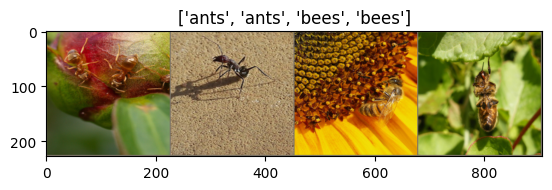

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6157 Acc: 0.6803

Epoch 1/4
----------
Loss: 0.5563 Acc: 0.7787

Epoch 2/4
----------
Loss: 0.4184 Acc: 0.8074

Epoch 3/4
----------
Loss: 0.6636 Acc: 0.7295

Epoch 4/4
----------
Loss: 0.5250 Acc: 0.7951



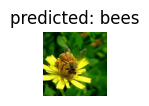

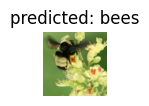

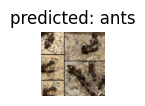

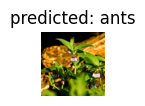

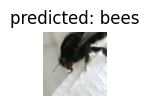

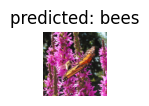

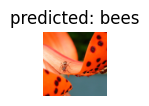

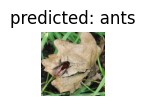

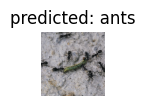

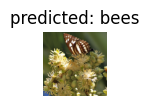

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


question 1



The significance of using data augmentations like resize, crop, etc., on training data is:

To increase the diversity of the training dataset, which helps improve the model's generalization ability and reduce overfitting.










question for 2nd

Training a ResNet model from scratch without using a pretrained model generally results in lower performance compared to using a pretrained model, especially when you have a limited amount of training data. This is because pretrained models leverage the features learned from large, diverse datasets (such as ImageNet) and can transfer this knowledge to new tasks, improving generalization and convergence speed.

When you train a ResNet from scratch (pretrained=False), the model has to learn all the features from the beginning, which can be challenging without sufficient data and computational resources. Here’s a summary of the expected performance differences:

Convergence Time: Training from scratch typically requires more epochs to converge.
Accuracy: The final accuracy is usually lower when training from scratch, particularly on smaller datasets.
Overfitting: Models trained from scratch are more prone to overfitting, especially if the dataset is small.
Example: CIFAR-10 Dataset
Assuming the use of a common benchmark dataset like CIFAR-10, here is a simplified comparison of performance metrics:

Pretrained ResNet (on CIFAR-10):

Test accuracy: Typically around 90% or higher
Training time: Faster convergence due to pretrained weights
ResNet from Scratch (on CIFAR-10):

Test accuracy: Often significantly lower, around 70-80% or less, depending on the training setup
Training time: Slower convergence, requiring more epochs and careful tuning


question 3

Using a pretrained ResNet model that was trained on a dataset significantly different from the ants vs bees dataset can still offer advantages, but the performance might not be as optimal as using a pretrained model trained on a more similar dataset. Here’s a breakdown of what you can expect:

Benefits of Using a Pretrained Model
Transfer of Low-Level Features: Early layers in the ResNet model capture low-level features like edges, textures, and shapes, which are common across different types of images. These features are generally useful regardless of the specific dataset.
Faster Convergence: Even if the pretrained model was trained on a very different dataset, it can still help in faster convergence during fine-tuning compared to training a model from scratch.
Reduced Training Time: Using a pretrained model reduces the amount of time and data required to train the network to achieve a reasonable performance.
Potential Drawbacks
Mismatch in High-Level Features: If the pretrained model was trained on a very different dataset (e.g., medical images vs. natural images), the high-level features learned might not be as relevant for distinguishing between ants and bees.
Suboptimal Performance: The model might not perform as well as it would with a more relevant pretrained model. Performance could be improved further by fine-tuning more layers or using more specific data augmentation techniques.
Practical Steps
To maximize the performance of a pretrained ResNet model in such a scenario, you can fine-tune the model on your specific dataset (ants vs bees). Fine-tuning involves retraining some or all of the layers of the network on the new data.

Here's how you can do it:

Load Pretrained Model: Load the pretrained ResNet model.
Replace Final Layer: Replace the final fully connected layer with a new layer that matches the number of classes in your ants vs bees dataset.
Fine-Tune: Fine-tune the model by training it on the ants vs bees dataset. You can choose to train all layers or just the final few layers.
